# Linear Classification

 Implement Linear Classification using pytorch. This consists of having fully connected layers connected one after the other and ReLu activation functions between them.
 
 Build a neural network with a minimun of 2 layers in order to do classification.

In [6]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data as utils
import time
import pdb
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

from network import Net

torch.manual_seed(1)    # reproducible

### Load data

In [7]:
def get_train_valid_loader(data_dir='../data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
#             normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
#             normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader(num_workers = 1, show_sample=False)

Files already downloaded and verified
Files already downloaded and verified


### Define the Neural Network

In [13]:
n_input = 32 * 32 * 3
n_classes = 10
learning_rate = 1e-3

net = Net(n_input=n_input, n_output=n_classes)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

print(net)

Net(
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)


### Train the network

In [14]:
def get_accuracy(dataloader):
    correct = 0
    total = 0
    for images, labels in iter(dataloader):
        predicted = net.predict(images)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [15]:
epochs = 10
accuracy_train = []
accuracy_val = []

for cur_epoch in range(epochs):
    start = time.time()
    # Train
    for images, labels in iter(trainloader):
        optimizer.zero_grad()
        outputs = net.forward(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
    # Test accuracy
    net.eval()
    with torch.no_grad():
        accuracy_train.append(get_accuracy(trainloader)) # Test on train data
        accuracy_val.append(get_accuracy(valloader)) # Test on validation data
                
    time_spent = time.time() - start
    start = time.time()
    
    print(f"Current epoch {cur_epoch}. Accuracy train: {accuracy_train[-1]:.3f}. "
          f"Accuracy validation: {accuracy_val[-1]:.3f}. Time spent: {time_spent:.3f}")

Current epoch 0. Accuracy train: 38.165. Accuracy validation: 40.200. Time spent: 71.935
Current epoch 1. Accuracy train: 42.851. Accuracy validation: 42.400. Time spent: 79.977
Current epoch 2. Accuracy train: 45.533. Accuracy validation: 45.900. Time spent: 82.214
Current epoch 3. Accuracy train: 46.988. Accuracy validation: 44.800. Time spent: 81.783
Current epoch 4. Accuracy train: 48.545. Accuracy validation: 46.900. Time spent: 80.851
Current epoch 5. Accuracy train: 50.600. Accuracy validation: 46.500. Time spent: 78.827
Current epoch 6. Accuracy train: 51.708. Accuracy validation: 49.300. Time spent: 50.932
Current epoch 7. Accuracy train: 52.480. Accuracy validation: 49.200. Time spent: 47.474
Current epoch 8. Accuracy train: 52.271. Accuracy validation: 47.300. Time spent: 61.434
Current epoch 9. Accuracy train: 54.071. Accuracy validation: 47.700. Time spent: 58.637


### Draw train and test accuracy over epochs

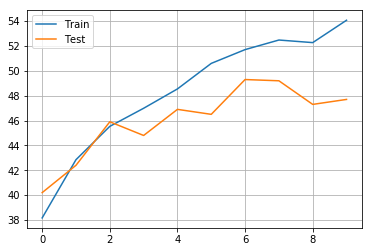

In [16]:
plt.figure()
plt.plot(range(epochs), accuracy_train, label="Train")
plt.plot(range(epochs), accuracy_val, label="Test")
plt.legend()
plt.grid()
plt.show()

### Save the model

In [18]:
get_accuracy(trainloader), get_accuracy(valloader)

(54.07142857142857, 47.7)

After training, the model should be saved to be tested on the test dataset or to be used in a real-life application. To save a model in pytorch:

In [19]:
torch.save(net.state_dict(), 'model.ckpt')

To load a pretrained model:

In [ ]:
path_model = "model.ckpt"

In [ ]:
net = Net(n_input=n_input, n_output=n_classes)

checkpoint = torch.load(path_model)
net.load_state_dict(checkpoint)

In [ ]:
get_accuracy(trainloader), get_accuracy(valloader)